## Pendulum Minimum Time

In [1]:
using TrajectoryOptimization
using Plots, LinearAlgebra

┌ Info: Recompiling stale cache file /home/taylor/.julia/compiled/v1.1/TrajectoryOptimization/UVgeA.ji for TrajectoryOptimization [c79d492b-0548-5874-b488-5a62c1d9d0ca]
└ @ Base loading.jl:1184
┌ Warning: Package TrajectoryOptimization does not have MatrixCalculus in its dependencies:
│ - If you have TrajectoryOptimization checked out for development and have
│   added MatrixCalculus as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with TrajectoryOptimization
└ Loading MatrixCalculus into TrajectoryOptimization from project dependency, future warnings for TrajectoryOptimization are suppressed.


Import the pendulum model

In [2]:
model = Dynamics.pendulum_model
n = model.n # number of states
m = model.m; # number of controls

dt = 0.1 # discretization time step
model_d = rk4(model,dt); # discrete time model

Define numerical type

In [3]:
T = Float64;

Define initial and goals states

In [5]:
x0 = [0.0;0.0]
xf = [π; 0.0]

2-element Array{Float64,1}:
 3.141592653589793
 0.0              

Define a cost function, e.g., quadratic

In [7]:
Q = Array(1e-3*Diagonal(I,n))
R = Array(1e-3*Diagonal(I,m))
Qf = Array(Diagonal(I,n)*0.0)
cost = LQRCost(Q,R,Qf,xf);

Define constraints

In [72]:
u_bnd = 2.
x_min = [-0.25; -0.001; -Inf]
x_max = [0.25; 1.001; Inf]
bnd = bound_constraint(n,m,x_min=x_min,x_max=x_max,u_min=-u_bnd,u_max=u_bnd,trim=true)

goal_con = goal_constraint(xf)

con = [bnd, goal_con];

Set options

In [71]:
verbose=false
opts_ilqr = iLQRSolverOptions{T}(verbose=false,live_plotting=:off)

opts_al = AugmentedLagrangianSolverOptions{T}(verbose=false,opts_uncon=opts_ilqr,
    iterations=30,penalty_scaling=10.0)

opts_altro = TrajectoryOptimization.ALTROSolverOptions{T}(verbose=false,opts_al=opts_al,R_minimum_time=15.0,
    dt_max=0.2,dt_min=1.0e-3);

Define a problem

In [74]:
N = 51
tf = 3.0
U = [ones(m) for k = 1:N-1]
dt = 0.06
obj = Objective(cost,N)
constraints = TrajectoryOptimization.ProblemConstraints(con,N)

prob = Problem(model_d,Objective(cost,N),U,constraints=TrajectoryOptimization.ProblemConstraints(con,N),dt=dt,x0=x0)
initial_controls!(prob, U);

Solve problem

In [75]:
solve!(prob, opts_altro) # solve with iLQR

Define minimum time problem

In [78]:
prob_mt = Problem(model_d,Objective(cost,N),U,constraints=TrajectoryOptimization.ProblemConstraints(con,N),dt=dt,x0=x0,tf=:min);

In [79]:
solve!(prob_mt, opts_altro) # solve with iLQR

Minimum Time Solve


In [80]:
x = [prob.X[k][1] for k = 1:N]
y = [prob.X[k][2] for k = 1:N]

x_min_time = [prob_mt.X[k][1] for k = 1:N]
y_min_time = [prob_mt.X[k][2] for k = 1:N];

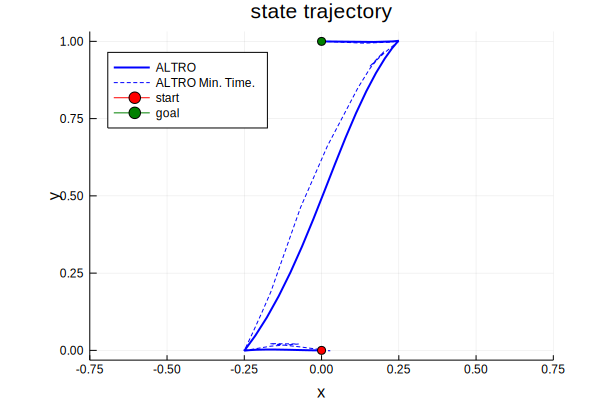

In [83]:
plot()
# plot_obstacles(circles,:orange)
plot!(x,y,xlabel="x",ylabel="y",label="ALTRO",legend=:topleft,color=:blue,width=2,ratio=:equal,title="state trajectory")
plot!(x_min_time,y_min_time,xlim=(-0.75,0.75),xlabel="x",ylabel="y",label="ALTRO Min. Time.",legend=:topleft,color=:blue,linestyle=:dash,width=1,ratio=:equal,title="state trajectory")

plot!((x[1],y[1]),marker=:circle,color=:red,label="start")
plot!((x[end],y[end]),marker=:circle,color=:green,label="goal")

In [84]:
tt = TrajectoryOptimization.total_time(prob)
tt_min_time = TrajectoryOptimization.total_time(prob_mt)

1.80440185654622

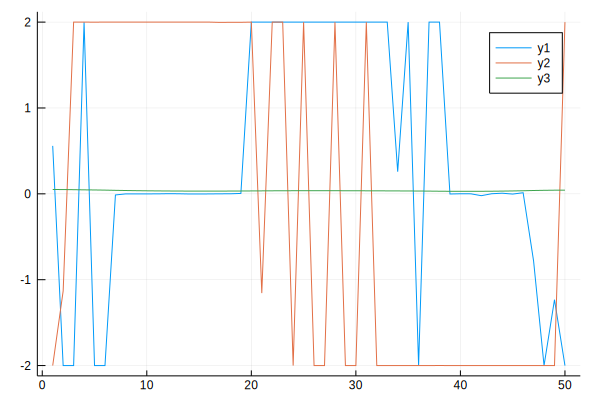

In [86]:
plot(prob_mt.U)